In [1]:
# !pip install opendatasets

In [2]:
import os # библиотека для работы с файловой системой
from pathlib import Path # pathlib - модуль, упрощающий работу с файлами и папками
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tfa
from keras.src.layers import SpatialDropout2D
from keras.src.saving.saving_lib import load_model

data_dir = './data' # путь к данным на диске

def convert_img_to_df(dataset):
  img_dir = Path(dataset)
  filename = list(img_dir.glob(r'**/*.jpg'))
  label = list(map(lambda x:os.path.split(os.path.split(x)[0])[1],filename))

  filename = pd.Series(filename,name='Filepath').astype(str)
  label = pd.Series(label,name='Label')
  img_df = pd.concat([filename,label],axis=1)
  return img_df

img_df = convert_img_to_df(data_dir)
img_df.head()

2025-05-24 14:40:43.244766: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-24 14:40:43.273953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748086843.309352  102483 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748086843.329892  102483 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748086843.414982  102483 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

,Filepath,Label
0,data/Angry/0346f330983a068db0633f96d4a13de873-...,Angry
1,data/Angry/1564075.jpg,Angry
2,data/Angry/19_1016_DISCIPLESHIP_How-to-Deal-Wi...,Angry
3,data/Angry/32209658.jpg,Angry
4,data/Angry/3710928.jpg,Angry


Проверим форму изображения

In [3]:
img = plt.imread(img_df['Filepath'].iloc[1])
img.shape

(1200, 1920, 3)

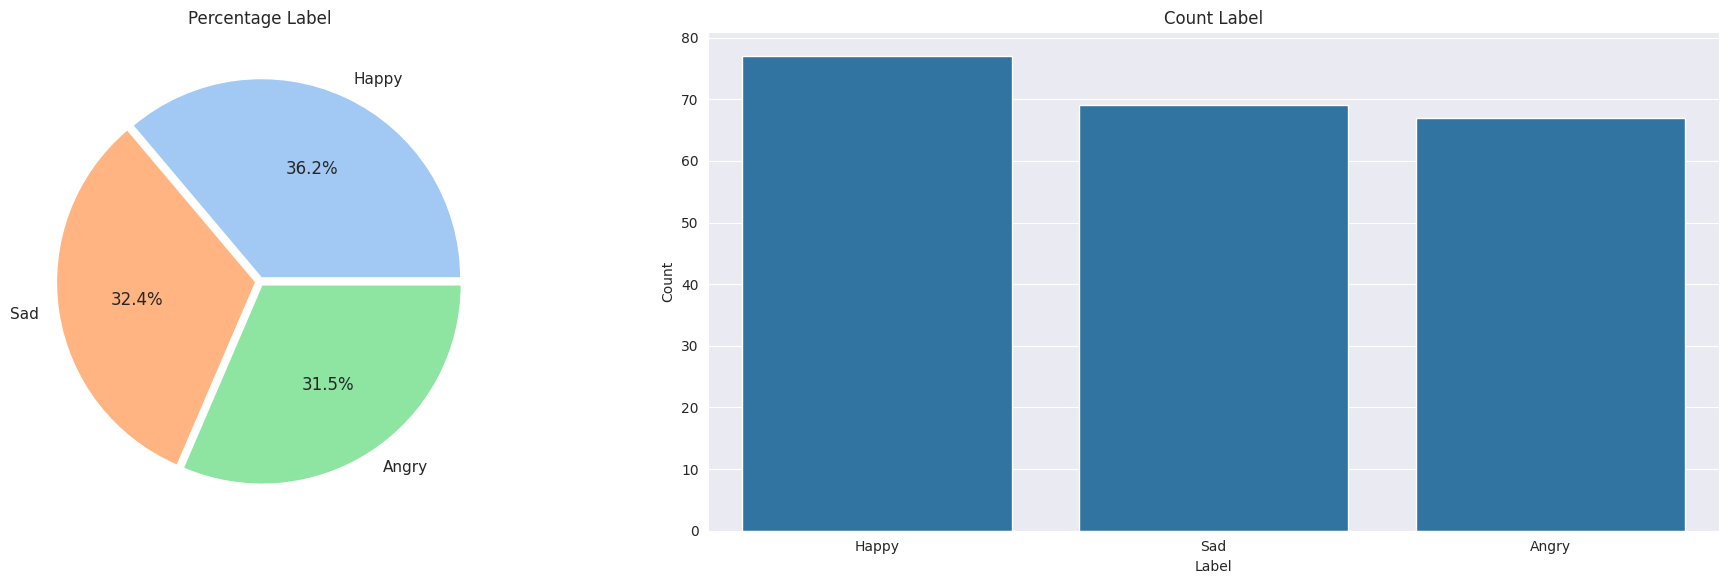

In [4]:
# Количество меток
label_count = img_df['Label'].value_counts()

# Настройки
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')
explode = [0.02]*len(label_count)

# Круговая диаграмма
axes[0].pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', colors=color, explode=explode)
axes[0].set_title('Percentage Label')

# Столбчатая диаграмма
sns.barplot(x=label_count.index, y=label_count.values, ax=axes[1])
axes[1].set_title('Count Label')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

# Отображаем
plt.tight_layout()
plt.show()

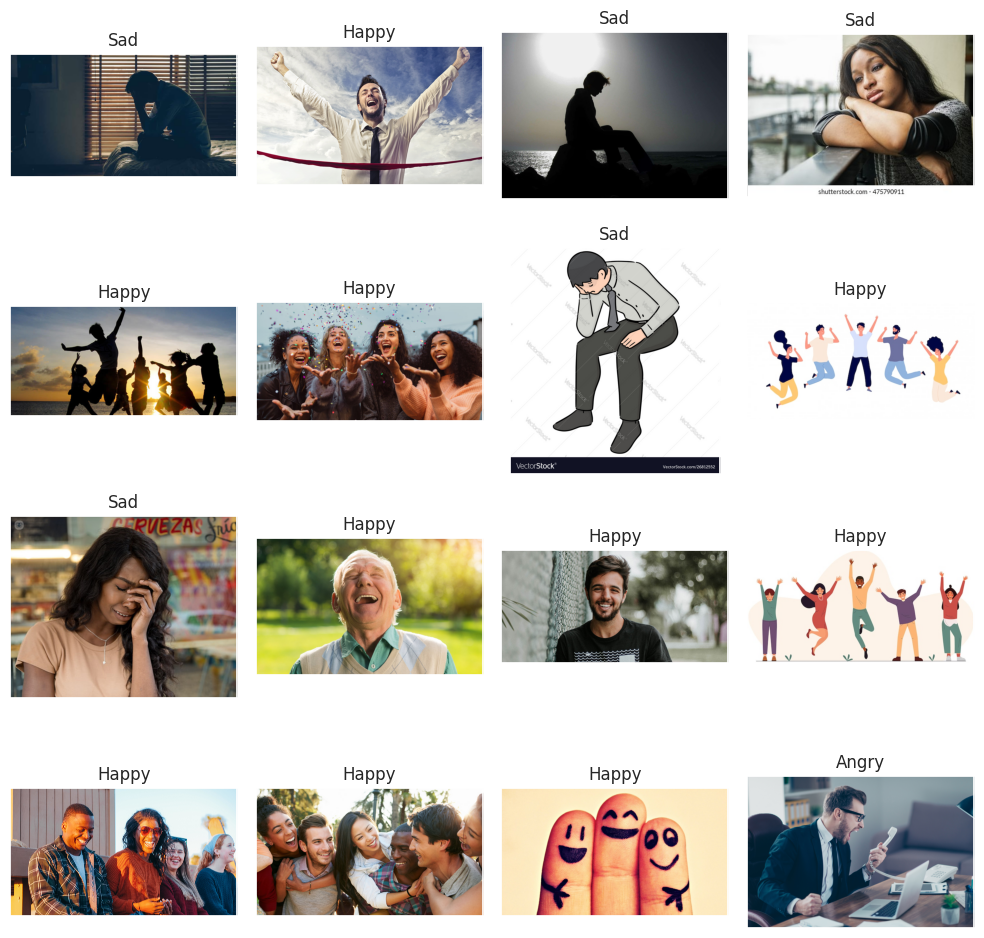

In [5]:
random_index = np.random.randint(0,len(img_df),16)
fig,axes = plt.subplots(nrows=4,ncols=4,figsize=(10,10),subplot_kw={'xticks':[],'yticks':[]})

for i,ax in enumerate(axes.flat):
  img = plt.imread(img_df['Filepath'].iloc[random_index[i]])
  ax.imshow(img)
  ax.set_title(img_df['Label'].iloc[random_index[i]])
plt.tight_layout()
plt.show()

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image

## Подбор гиперпараметров модели сверточной нейронной сети

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Split data
img_train , test = train_test_split(img_df,test_size=0.1)
train, val = train_test_split(img_train,test_size=0.2)

#For train
datagen = ImageDataGenerator(rescale=1./255,
                             width_shift_range=0.15,
                             height_shift_range=0.15,
                             horizontal_flip=True,
                             vertical_flip=True)

# For test
datagen_test = ImageDataGenerator(rescale=1./255)

train_set = datagen.flow_from_dataframe(dataframe=train,
                                        x_col='Filepath',
                                        y_col='Label',
                                        batch_size=32,
                                        target_size=(224,224),
                                        shuffle=True,
                                        seed=42,
                                        class_mode='categorical'
                                        )

val_set = datagen_test.flow_from_dataframe(dataframe=val,
                                        x_col='Filepath',
                                        y_col='Label',
                                        batch_size=32,
                                        target_size=(224,224),
                                        shuffle=True,
                                        seed=42,
                                        class_mode='categorical'
                                        )

test_set = datagen_test.flow_from_dataframe(dataframe=test,
                                        x_col='Filepath',
                                        y_col='Label',
                                        batch_size=32,
                                        target_size=(224,224),
                                        shuffle=False,
                                        seed=42,
                                        class_mode='categorical'
                                        )

Found 152 validated image filenames belonging to 3 classes.
Found 39 validated image filenames belonging to 3 classes.
Found 22 validated image filenames belonging to 3 classes.


In [82]:
from keras import Sequential
from keras.layers import Dense, MaxPool2D,Conv2D,Flatten,Dropout

model = Sequential()
model.add(Conv2D(10,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(10,(3,3),activation='relu'))
model.add(MaxPool2D((2,2),padding='valid'))

model.add(Conv2D(10,(3,3),activation='relu'))
model.add(Conv2D(10,(3,3),activation='relu'))
model.add(MaxPool2D((2,2),padding='valid'))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(3,activation='softmax'))

model.summary()

/home/glebmavi/.virtualenvs/Neiro/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_134 (Conv2D)             │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_135 (Conv2D)             │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 110, 110, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_136 (Conv2D)             │ (None, 108, 108, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_137 (Conv2D)             │ (None, 106, 106, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 53, 53, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 28090)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 128)            │     3,595,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,599,045 (13.73 MB)

 Trainable params: 3,599,045 (13.73 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(train_set,
                    steps_per_epoch=len(train_set),
                    validation_data=val_set,
                    validation_steps=len(val_set),
                    epochs=20,
                    verbose=1)

/home/glebmavi/.virtualenvs/Neiro/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 761ms/step - accuracy: 0.2655 - loss: 1.5124 - val_accuracy: 0.3333 - val_loss: 1.2041
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step - accuracy: 0.3246 - loss: 1.2463 - val_accuracy: 0.3333 - val_loss: 1.0875
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 664ms/step - accuracy: 0.3320 - loss: 1.1216 - val_accuracy: 0.2564 - val_loss: 1.0962
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 683ms/step - accuracy: 0.3518 - loss: 1.0749 - val_accuracy: 0.2821 - val_loss: 1.0828
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 637ms/step - accuracy: 0.4421 - loss: 1.0671 - val_accuracy: 0.3846 - val_loss: 1.0722
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step - accuracy: 0.4297 - loss: 1.0682 - val_accuracy: 0.3846 - val_loss: 1.0752
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step - accuracy: 0.4313 - loss: 1.0564 - val_accuracy: 0.2564 - val_loss: 1.1302
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step - accuracy: 0.3655 - loss: 1.0862 - val_accuracy: 0.2821 - val_loss:

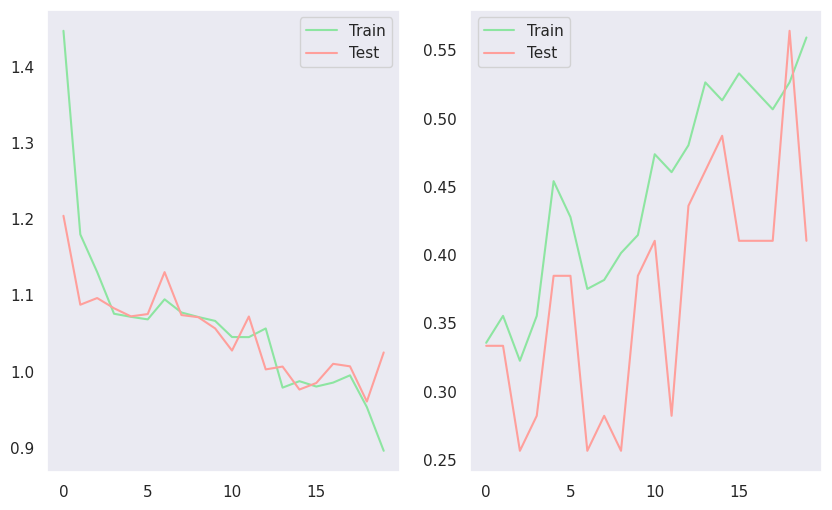

In [84]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='Train',c='g')
plt.plot(history.history['val_loss'],label='Test',c='r')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label='Train',c='g')
plt.plot(history.history['val_accuracy'],label='Test',c='r')
plt.grid()
plt.legend()
plt.show()

In [85]:
score = model.evaluate(test_set,steps=len(test_set),verbose=0)
print('Loss: {:.2f}'.format(score[0]))
print('Accuracy: {:.2f}'.format(score[1]))

/home/glebmavi/.virtualenvs/Neiro/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Loss: 0.72
Accuracy: 0.64


In [28]:
from keras.src.applications.convnext import StochasticDepth
from keras.src.layers import (Reshape, Multiply, RandomRotation, RandomZoom)


def se_block(input_tensor, ratio=4):
    channels = input_tensor.shape[-1]
    # Squeeze: global spatial information into channel descriptor
    se = GlobalAveragePooling2D()(input_tensor)
    # Excitation: two FC layers with a bottleneck
    se = Dense(channels // ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)

    se = Reshape((1, 1, channels))(se)
    return Multiply()([input_tensor, se])

def res_block(x, filters, stride=1, survival=0.9, ratio=2):
    shortcut = x

    # --- First conv ---
    x = Conv2D(filters, 3, strides=stride, padding='same',
               kernel_initializer='he_normal', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # --- Second conv ---
    x = Conv2D(filters, 3, padding='same',
               kernel_initializer='he_normal', use_bias=False)(x)
    x = BatchNormalization()(x)

    # --- Squeeze–Excite ---
    x = se_block(x, ratio)

    # ----- Regularisation -----
    x = SpatialDropout2D(0.05)(x)
    x = StochasticDepth(1 - survival)(x)

    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = Conv2D(filters, 1, strides=stride,
                          kernel_initializer='he_normal',
                          use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x


def build_emotion_resnet(input_shape=(224, 224, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    aug = keras.Sequential([
        RandomZoom(0.15, 0.15),          # in/out zoom
        RandomRotation(0.10),            # ±10°
    ], name="augment")

    x = aug(inputs)

    # Initial conv + pool
    x = Conv2D(32, 3, padding='same',
               kernel_initializer='he_normal', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # stage 1 – 2× residual, 32 filters
    for _ in range(2):
        x = res_block(x, 32)

    # stage 2 – 64 filters
    x = res_block(x, 64, stride=2)
    x = res_block(x, 64)

    # stage 3 – 128 filters
    x = res_block(x, 128, stride=2)

    x = Dense(32, activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

model_better = build_emotion_resnet()

model_better.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augment             │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 224, 224,  │        864 │ augment[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_35       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 224, 224,  │      9,216 │ activation_35[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 224, 224,  │      9,216 │ activation_36[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 16)        │        528 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 32)        │        544 │ dense_41[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_16          │ (None, 1, 1, 32)  │          0 │ dense_42[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_16         │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Multiply)          │ 32)               │            │ reshape_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 224, 224,  │          0 │ multiply_16[0][0] │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stochastic_depth_16 │ (None, 224, 224,  │          0 │ spatial_dropout2… │
│ (StochasticDepth)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,855,651 (26.15 MB)

 Trainable params: 6,853,923 (26.15 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [48]:
# More train data

new_data_dir = './new_data'

new_img_df = convert_img_to_df(new_data_dir)

# append new_img_df with img_df
img_df = pd.concat([img_df, new_img_df], ignore_index=True)
img_df = img_df.sample(n=1500, random_state=42)

# 2. Re-split into train / test / val
img_train, test = train_test_split(img_df, test_size=0.1, random_state=42)
train, val    = train_test_split(img_train, test_size=0.2, random_state=42)

# 3. (Re-)create your generators
train_set = datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath', y_col='Label',
    batch_size=32, target_size=(224,224),
    shuffle=True, seed=42,
    class_mode='categorical'
)

val_set = datagen_test.flow_from_dataframe(
    dataframe=val,
    x_col='Filepath', y_col='Label',
    batch_size=32, target_size=(224,224),
    shuffle=True, seed=42,
    class_mode='categorical'
)

test_set = datagen_test.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath', y_col='Label',
    batch_size=32, target_size=(224,224),
    shuffle=False, seed=42,
    class_mode='categorical'
)

Found 1080 validated image filenames belonging to 3 classes.
Found 270 validated image filenames belonging to 3 classes.
Found 150 validated image filenames belonging to 3 classes.


In [63]:
from keras.src.optimizers.schedules import CosineDecay
from keras.src.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint
from keras.src.losses import CategoricalCrossentropy
from keras.src.optimizers import Adam, AdamW

MODEL_PATH = 'best_val_acc.weights.h5'

def compile_model(m):
    m.compile(
        optimizer=AdamW(learning_rate=6e-4, weight_decay=5e-4, clipnorm=1.0),
        loss=CategoricalCrossentropy(label_smoothing=0.05),
        metrics=['accuracy']
    )

if os.path.exists(MODEL_PATH):
    model_better = build_emotion_resnet()
    compile_model(model_better)
    model_better.load_weights(MODEL_PATH)
    print('model loaded')
else:
    model_better = build_emotion_resnet()
    compile_model(model_better)



cos_decay = CosineDecay(
    initial_learning_rate=6e-4,
    decay_steps=len(train_set) * 80
)

def schedule_fn(epoch, lr):
    return float(cos_decay(epoch).numpy())

clr = LearningRateScheduler(schedule_fn)
es  = EarlyStopping(
          monitor='val_loss', patience=10, restore_best_weights=True)
mc = ModelCheckpoint(
        MODEL_PATH, monitor='val_accuracy',
        mode='max', save_best_only=True, save_weights_only=True)

history_better = model_better.fit(
    train_set, validation_data=val_set,
    epochs=20, callbacks=[clr, es, mc], verbose=1)

model_better.load_weights(MODEL_PATH)

/home/glebmavi/.virtualenvs/Neiro/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 132 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/glebmavi/.virtualenvs/Neiro/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


model loaded
Epoch 1/20


E0000 00:00:1748081017.903890   46716 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_21_1/spatial_dropout2d_51_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3339 - loss: 1.1935 - val_accuracy: 0.3590 - val_loss: 1.4679 - learning_rate: 6.0000e-04
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 770ms/step - accuracy: 0.3512 - loss: 1.0737 - val_accuracy: 0.2821 - val_loss: 1.5739 - learning_rate: 5.9999e-04
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 817ms/step - accuracy: 0.4222 - loss: 1.0343 - val_accuracy: 0.3077 - val_loss: 1.1184 - learning_rate: 5.9996e-04
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 758ms/step - accuracy: 0.4155 - loss: 1.0119 - val_accuracy: 0.3333 - val_loss: 1.1402 - learning_rate: 5.9992e-04
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 870ms/step - accuracy: 0.4431 - loss: 1.0867 - val_accuracy: 0.3590 - val_loss: 1.1179 - learning_rate: 5.9985e-04
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 652ms/step - accuracy: 0.4697 - loss: 1.0226 - val_accuracy: 0.3846 - val_loss: 1.0883 - learning_rate: 5.9977e-04
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 755ms/step - accuracy: 0.4083 - loss: 1.0164 - val

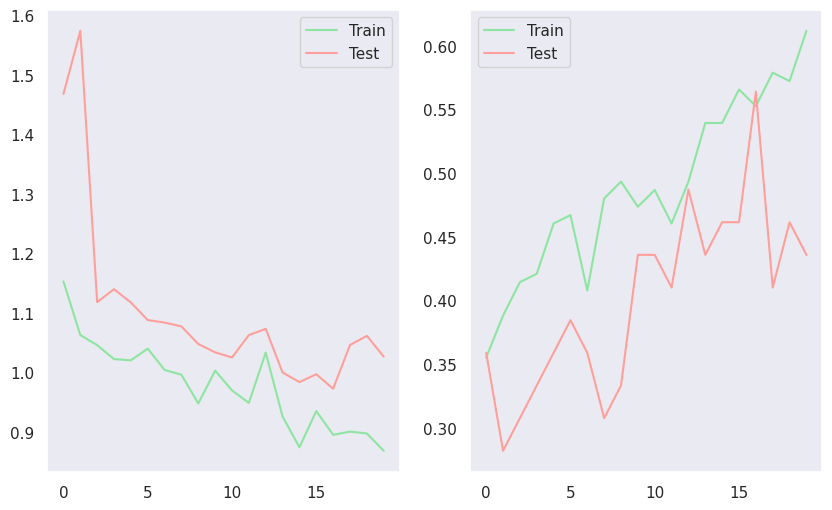

In [64]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history_better.history['loss'],label='Train',c='g')
plt.plot(history_better.history['val_loss'],label='Test',c='r')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_better.history['accuracy'],label='Train',c='g')
plt.plot(history_better.history['val_accuracy'],label='Test',c='r')
plt.grid()
plt.legend()
plt.show()

In [65]:
score = model_better.evaluate(test_set,steps=len(test_set),verbose=0)
print('Loss: {:.2f}'.format(score[0]))
print('Accuracy: {:.2f}'.format(score[1]))

/home/glebmavi/.virtualenvs/Neiro/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Loss: 0.91
Accuracy: 0.68


## Тонкая настройка модели VGG16

In [19]:
from keras.applications.vgg16 import VGG16, preprocess_input

datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                             width_shift_range=0.15,
                             height_shift_range=0.15,
                             vertical_flip=True,
                             horizontal_flip=True)
datagen_test = ImageDataGenerator(preprocessing_function=preprocess_input)
train_set = datagen.flow_from_dataframe(dataframe=train,
                                        x_col='Filepath',
                                        y_col= 'Label',
                                        batch_size=32,
                                        class_mode='categorical',
                                        seed = 42,
                                        shuffle=True,
                                        target_size=(224,224))

val_set = datagen_test.flow_from_dataframe(dataframe=val,
                                        x_col='Filepath',
                                        y_col= 'Label',
                                        batch_size=32,
                                        class_mode='categorical',
                                        seed = 42,
                                        shuffle=True,
                                        target_size=(224,224))

test_set = datagen_test.flow_from_dataframe(dataframe=test,
                                        x_col='Filepath',
                                        y_col= 'Label',
                                        batch_size=32,
                                        class_mode='categorical',
                                        seed = 42,
                                        shuffle=False,
                                        target_size=(224,224))

In [11]:
from keras import Sequential
from keras.layers import (
    Conv2D, Activation, Add,
    MaxPool2D, Dropout, GlobalAveragePooling2D, Dense, Flatten
)

base_vgg = VGG16(weights='imagenet',
                   input_shape=(224,224,3),
                   include_top=False)
base_vgg.trainable = False
vgg_model = Sequential()
vgg_model.add(base_vgg)
vgg_model.add(Flatten())
vgg_model.add(Dense(128,activation='relu'))
vgg_model.add(Dropout(0.4))
vgg_model.add(Dense(3,activation='softmax'))

vgg_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
vgg_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_vgg = vgg_model.fit(train_set,
                                  steps_per_epoch=len(train_set),
                                  validation_data=val_set,
                                  validation_steps=len(val_set),
                                  epochs=20,
                                  verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,467 (68.38 MB)

 Trainable params: 3,211,779 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

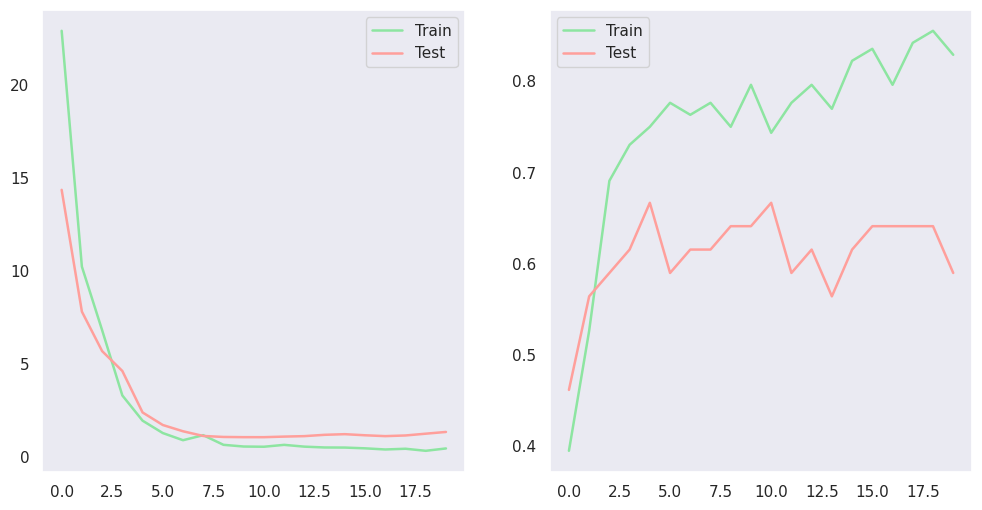

In [13]:
sns.set_theme(style='darkgrid',palette='pastel')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history_vgg.history['loss'],label='Train',c='g',lw=1.8)
plt.plot(history_vgg.history['val_loss'],label='Test',c='r',lw=1.8)
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history_vgg.history['accuracy'],label='Train',c='g',lw=1.8)
plt.plot(history_vgg.history['val_accuracy'],label='Test',c='r',lw=1.8)
plt.legend()
plt.grid()

plt.show()

In [10]:
score =vgg_model.evaluate(test_set,steps=len(test_set),verbose=0)
print('Loss: {:.2f}'.format(score[0]))
print('Accuracy: {:.2f}'.format(score[1]))

I0000 00:00:1748086903.590957  102483 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/glebmavi/.virtualenvs/Neiro/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/glebmavi/.virtualenvs/Neiro/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


VGG16 weights loaded.
Epoch 1/10


I0000 00:00:1748086907.615977  102770 service.cc:152] XLA service 0x7f90a4022760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748086907.616034  102770 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-05-24 14:41:47.646673: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748086907.905955  102770 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/5 ━━━━━━━━━━━━━━━━━━━━ 34s 9s/step - accuracy: 0.4583 - loss: 1.9208 - prec: 0.4091 - rec: 0.3750

I0000 00:00:1748086915.084363  102770 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.5188 - loss: 1.4584 - prec: 0.5262 - rec: 0.4746 - val_accuracy: 0.5128 - val_loss: 3.9383 - val_prec: 0.5000 - val_rec: 0.4872 - learning_rate: 6.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 775ms/step - accuracy: 0.5986 - loss: 1.0132 - prec: 0.6288 - rec: 0.5707 - val_accuracy: 0.5897 - val_loss: 2.6016 - val_prec: 0.5897 - val_rec: 0.5897 - learning_rate: 5.9999e-04
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 747ms/step - accuracy: 0.5972 - loss: 0.8990 - prec: 0.6077 - rec: 0.5675 - val_accuracy: 0.6154 - val_loss: 1.8599 - val_prec: 0.6154 - val_rec: 0.6154 - learning_rate: 5.9996e-04
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 702ms/step - accuracy: 0.6760 - loss: 0.7310 - prec: 0.6947 - rec: 0.6551 - val_accuracy: 0.6154 - val_loss: 1.5634 - val_prec: 0.6316 - val_rec: 0.6154 - learning_rate: 5.9992e-04
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 781ms/step - accuracy: 0.6696 - loss: 0.7099 - prec: 0.6901 - rec: 0.6559 - val_accuracy: 0.64

In [17]:
from keras.src.metrics import Precision, Recall
from keras.layers import (
    Conv2D, Activation, Add,
    Dropout, GlobalAveragePooling2D, Dense, Flatten,
BatchNormalization
)
from keras.src.optimizers import Adam
from keras.src.optimizers.schedules import CosineDecay
from keras import Sequential, Input, Model
from keras.src.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint

MODEL_PATH_VGG = 'vgg_best_val_acc.weights.h5'


inputs = Input(shape=(224, 224, 3))
base = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(3, activation='softmax')(x)

vgg_model_better = Model(inputs, outputs)

vgg_model_better.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             Precision(name='prec'),
             Recall(name='rec')]
)

if os.path.exists(MODEL_PATH_VGG):
    vgg_model_better.load_weights(MODEL_PATH_VGG)
    print('VGG16 weights loaded.')

cos_decay = CosineDecay(
    initial_learning_rate=6e-4,
    decay_steps=len(train_set) * 80
)

def schedule_fn(epoch, lr):
    return float(cos_decay(epoch).numpy())

clr = LearningRateScheduler(schedule_fn)
es  = EarlyStopping(
          monitor='val_loss', patience=10, restore_best_weights=True)
mc = ModelCheckpoint(
        MODEL_PATH_VGG, monitor='val_accuracy',
        mode='max', save_best_only=True, save_weights_only=True)

history_vgg_better = vgg_model_better.fit(
    train_set,
    steps_per_epoch=len(train_set),
    validation_data=val_set,
    validation_steps=len(val_set),
    callbacks=[es, mc, clr],
    epochs=10,
    verbose=1
)

# ----- 5. fine-tuning -----
for layer in base.layers[-8:]:   # last 2 convolutional blocks ≈ 8 layers
    layer.trainable = True

vgg_model_better.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             Precision(name='prec'),
             Recall(name='rec')]
)

history_vgg_better = vgg_model_better.fit(
    train_set,
    validation_data=val_set,
    epochs=20,
    callbacks=[es, mc, clr],
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           77

 Total params: 41,073,483 (156.68 MB)

 Trainable params: 13,112,323 (50.02 MB)

 Non-trainable params: 1,736,512 (6.62 MB)

 Optimizer params: 26,224,648 (100.04 MB)

In [12]:
sns.set_theme(style='darkgrid',palette='pastel')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history_vgg_better.history['loss'],label='Train',c='g',lw=1.8)
plt.plot(history_vgg_better.history['val_loss'],label='Test',c='r',lw=1.8)
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history_vgg_better.history['accuracy'],label='Train',c='g',lw=1.8)
plt.plot(history_vgg_better.history['val_accuracy'],label='Test',c='r',lw=1.8)
plt.legend()
plt.grid()

plt.show()

/home/glebmavi/.virtualenvs/Neiro/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-05-24 14:44:48.625581: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_272', 4 bytes spill stores, 4 bytes spill loads



Loss: 2.04
Accuracy: 0.64


In [14]:
score = vgg_model_better.evaluate(test_set,steps=len(test_set),verbose=0)
print('Loss: {:.2f}'.format(score[0]))
print('Accuracy: {:.2f}'.format(score[1]))

In [35]:
labels = test_set.class_indices
labels = dict((v,k) for k,v in labels.items())

In [15]:
pred = vgg_model.predict(test_set)
pred = np.argmax(pred,axis=1)
pred = [labels[k] for k in pred]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


In [43]:
pred_vgg = vgg_model_better.predict(test_set)
pred_vgg = np.argmax(pred_vgg,axis=1)
pred_vgg = [labels[k] for k in pred_vgg]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step


In [16]:
from sklearn.metrics import accuracy_score,classification_report

y_test = list(test.Label)

print('Accuracy Score: {:.3f}'.format(accuracy_score(y_test,pred)))
print(classification_report(y_test,pred))

Accuracy Score: 0.636
              precision    recall  f1-score   support

       Angry       0.57      0.80      0.67         5
       Happy       0.58      0.88      0.70         8
         Sad       1.00      0.33      0.50         9

    accuracy                           0.64        22
   macro avg       0.72      0.67      0.62        22
weighted avg       0.75      0.64      0.61        22



In [44]:
from sklearn.metrics import accuracy_score,classification_report

y_test = list(test.Label)

print('Accuracy Score: {:.3f}'.format(accuracy_score(y_test,pred_vgg)))
print(classification_report(y_test,pred_vgg))

Accuracy Score: 0.409
              precision    recall  f1-score   support

       Angry       0.45      0.45      0.45        11
       Happy       0.30      0.50      0.38         6
         Sad       1.00      0.20      0.33         5

    accuracy                           0.41        22
   macro avg       0.58      0.38      0.39        22
weighted avg       0.54      0.41      0.41        22



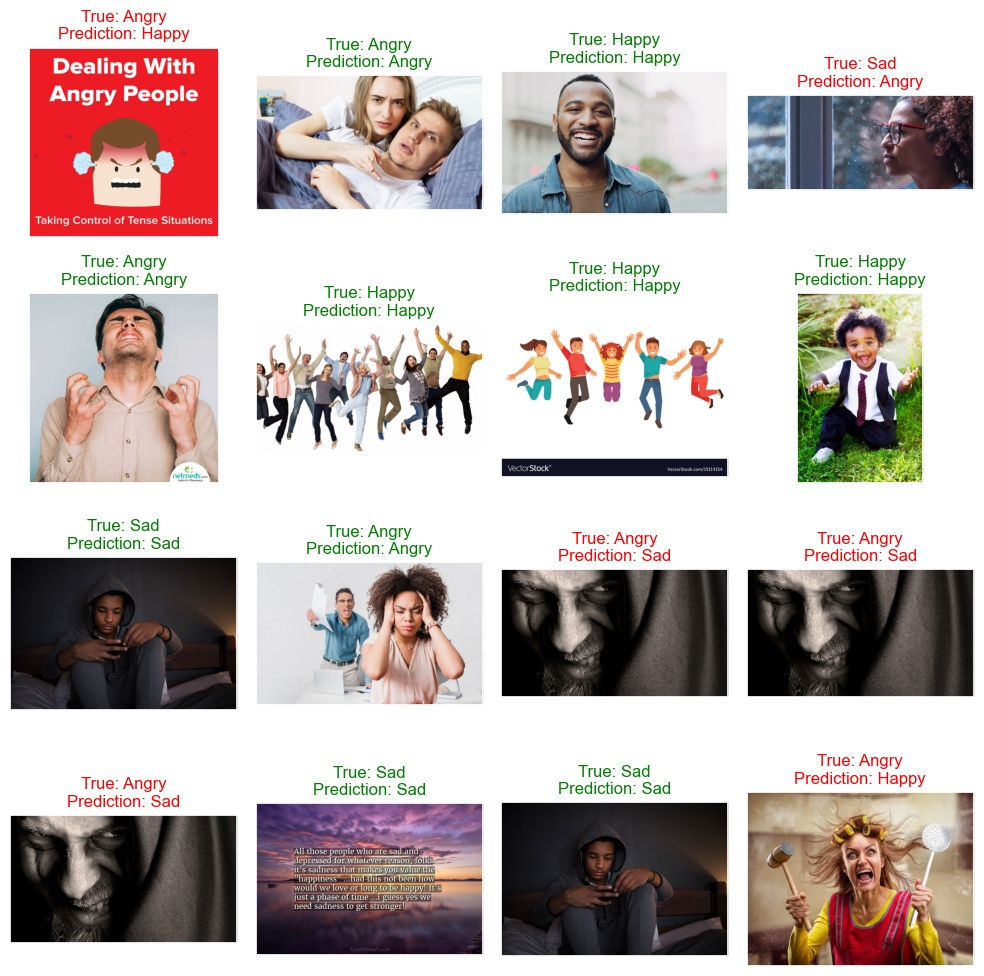

In [35]:
index_random = np.random.randint(0,len(test),16)
fig,axes = plt.subplots(nrows=4, ncols=4,figsize=(10,10),subplot_kw={'xticks':[],'yticks':[]})

for i ,ax in enumerate(axes.flat):
  img = plt.imread(test['Filepath'].iloc[index_random[i]])
  ax.imshow(img)
  if test['Label'].iloc[index_random[i]] == pred[index_random[i]]:
    color = 'green'
  else:
    color = 'red'
  ax.set_title(f'True: {test.Label.iloc[index_random[i]]}\nPrediction: {pred[index_random[i]]}',color=color)

plt.tight_layout()
plt.show()